In [45]:
# imports

from easyocr import Reader
import argparse
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# pripeare model

In [46]:
current_dir = os.getcwd()

In [47]:
# loading the data required for detecting the license plates using cascade classifier.
plate_cascade_path = os.path.join(current_dir, '../models/haarcascade_ua_license_plate.xml')
plate_cascade = cv2.CascadeClassifier(plate_cascade_path)

In [48]:
def detect_plate(img, text = ''): # the function detects and performs blurring on the number plate.
    plate_img = img.copy() # first copy of the image
    reg_of_intr = img.copy() # second copy of the image
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.4, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        plate = reg_of_intr[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate

In [49]:
def display(img_, title='', fontsize=30):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

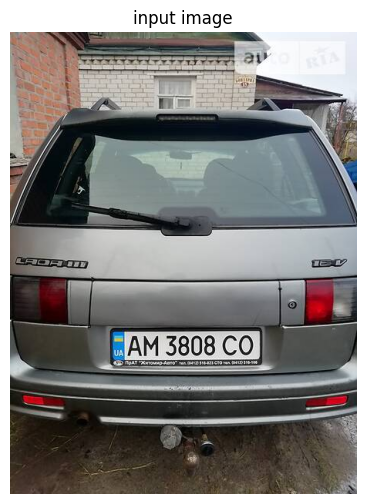

In [50]:
image_path = os.path.join(current_dir, '../images/AM3808CO.jpg')
img = cv2.imread(image_path)
display(img, 'input image')

In [51]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

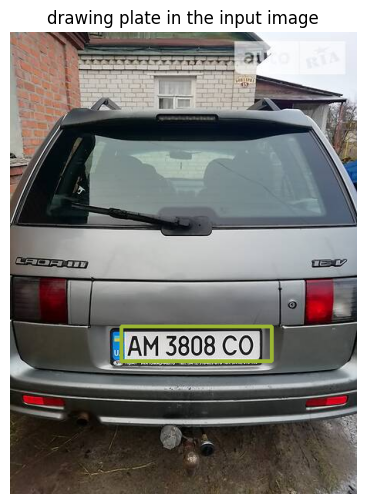

In [52]:
display(output_img, 'drawing plate in the input image')

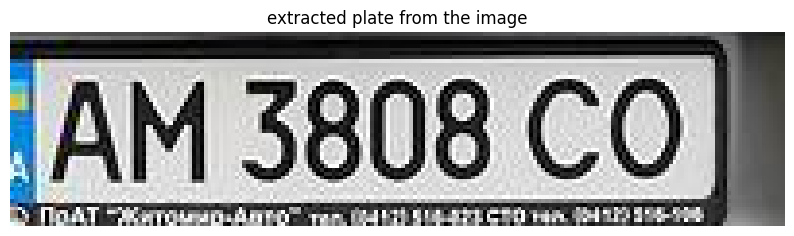

In [53]:
display(plate, 'extracted plate from the image')

In [54]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('../images/contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (76, 202, 102), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
            #print(img_res)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [55]:
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75)) # Resize the image to a fixed size
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Apply binary thresholding
    img_binary_lp = cv2.erode(img_binary_lp, (3,3)) # Apply erosion to remove noise
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3)) # Apply dilation to restore original size

    LP_WIDTH = img_binary_lp.shape[0] # Get the width of the license plate
    LP_HEIGHT = img_binary_lp.shape[1] # Get the height of the license plate

    # Make borders white
    img_binary_lp[0:3,:] = 255 # Minimum character height
    img_binary_lp[:,0:3] = 255 # Maximum character height
    img_binary_lp[72:75,:] = 255 # Minimum character width
    img_binary_lp[:,330:333] = 255 # Maximum character width

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray') # Display the binary image
    plt.show()
    cv2.imwrite('../images/contour.jpg',img_binary_lp) # Save the binary image to a file

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp) # Find character contours

    return char_list # Return the list of character contours

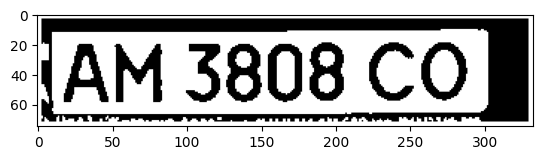

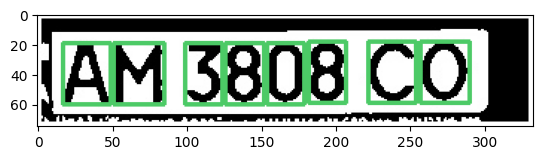

In [56]:
char = segment_characters(plate)

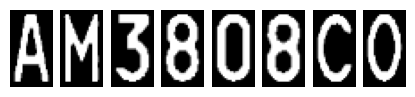

In [57]:
num_chars_to_display = min(10, len(char))

for i in range(num_chars_to_display):
    plt.subplot(1, 10, i+1)
    if i < len(char):
        plt.imshow(char[i], cmap='gray')
    plt.axis('off')

# model Easyocr

In [58]:
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

## Testing with the license plate number 

In [59]:
# Direct assignments for Jupyter
image_path = "../images/ВТ5390ВМ.jpg"  # Replace with your image path
langs = ["en"]  # List of languages for OCR
use_gpu = False  # Set to True if you want to use GPU and it's available

In [60]:
# Load the input image from disk
image = cv2.imread(image_path)

In [61]:
# OCR the input image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(image)

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


In [62]:
# Loop over the results
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

[INFO] 0.8422: BT 5390 BM
[INFO] 0.1679: U2


In [63]:
# Convert BGR (OpenCV) to RGB (Matplotlib)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

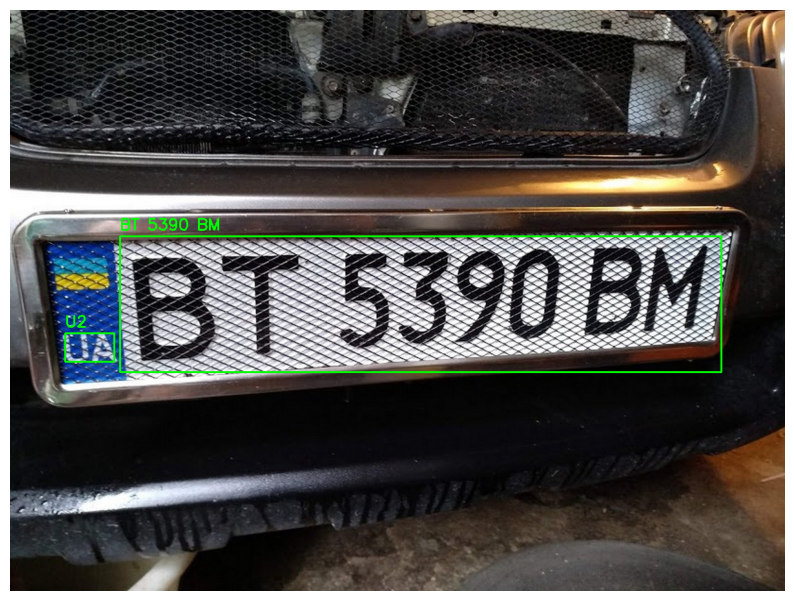

In [64]:
# Show the output image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

## Test 11

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.8198: 'AE 7094HC


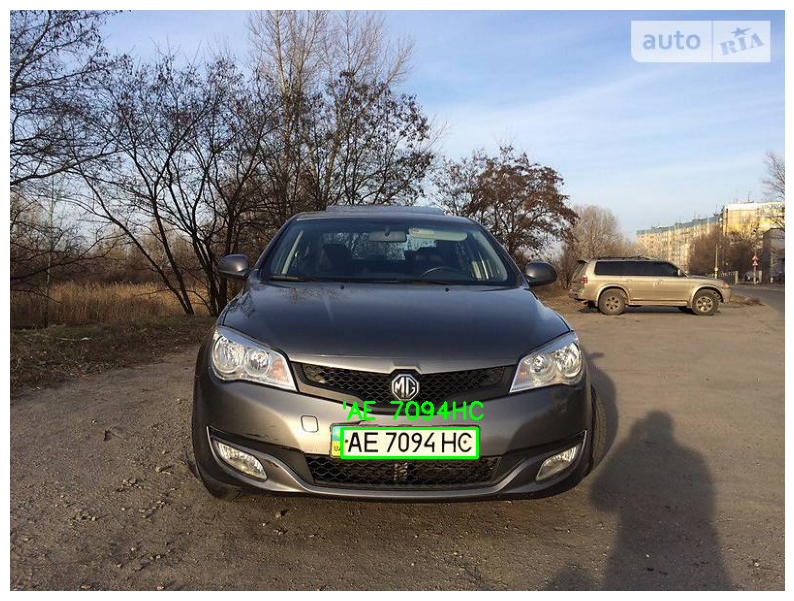

In [65]:
# Image path and settings
image_path = "../images/AE7094HC.jpg"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()


## Test 3

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.2860: 72)
[INFO] 0.3786: HHAR 024ML
[INFO] 0.0454: J
[INFO] 0.7063: 1
[INFO] 0.0000: 
[INFO] 0.0717: 2
[INFO] 0.4939: J
[INFO] 0.4006: 1
[INFO] 0.1753: L
[INFO] 0.1059: 1
[INFO] 0.1759: 0
[INFO] 0.0763: 3tn
[INFO] 0.0448: "nsth
[INFO] 0.7132: 1
[INFO] 0.3719: 1
[INFO] 0.0240: ~in
[INFO] 0.0528: 41442n4
[INFO] 0.4816: 1


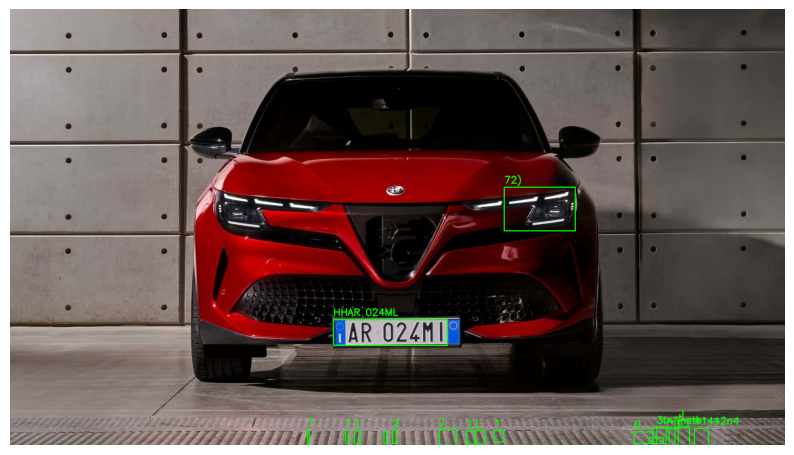

In [66]:
# Image path and settings
image_path = "../images/alfa-romeo-milano-2.jpg"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

## Test 4

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.5768: 41
[INFO] 0.7364: AM 3808 CQ


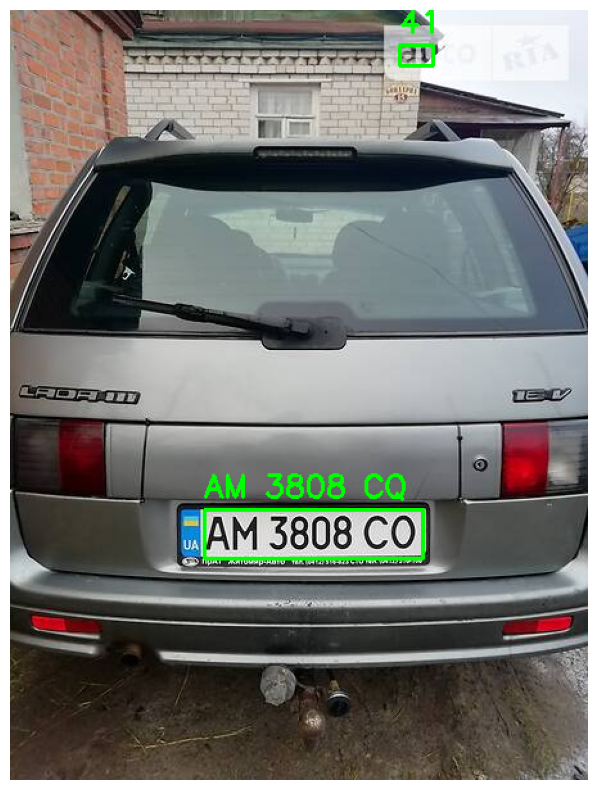

In [67]:
# Image path and settings
image_path = "../images/AM3808CO.jpg"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()



## Test 5

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.5165: 2r0
[INFO] 0.8263: SN66 XMZ


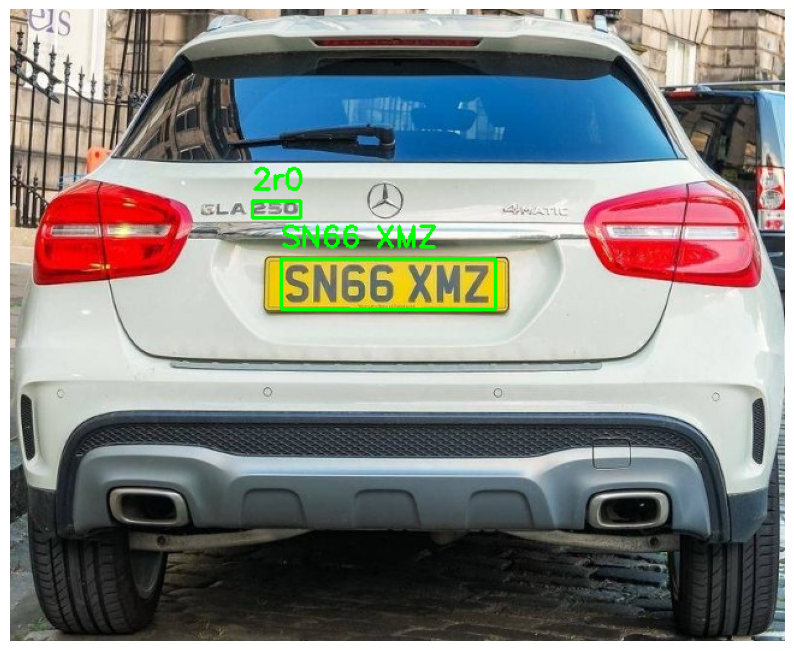

In [68]:
# Image path and settings
image_path = "../images/SN66XMZ.jpg"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()




## Test 6

In [69]:
# Image path and settings
image_path = "/Users/olgatsyban/Documents/car6.png"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()




[ WARN:0@11485.001] global loadsave.cpp:241 findDecoder imread_('/Users/olgatsyban/Documents/car6.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Test 8

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.9905: 1696EM
[INFO] 0.9830: AM


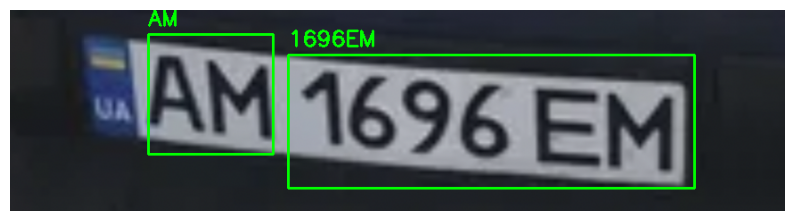

In [ ]:
# Image path and settings
image_path = "/Users/olgatsyban/Documents/car8.png"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()




## Test 9

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.9996: A
[INFO] 0.8967: 0001 S


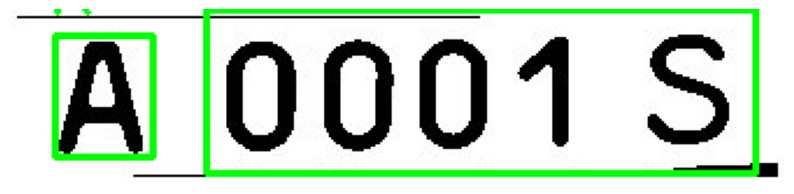

In [ ]:
# Image path and settings
image_path = "/Users/olgatsyban/Documents/car9.png"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

## Test 10

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.9988: CA
[INFO] 0.9797: 2218
[INFO] 0.8635: T


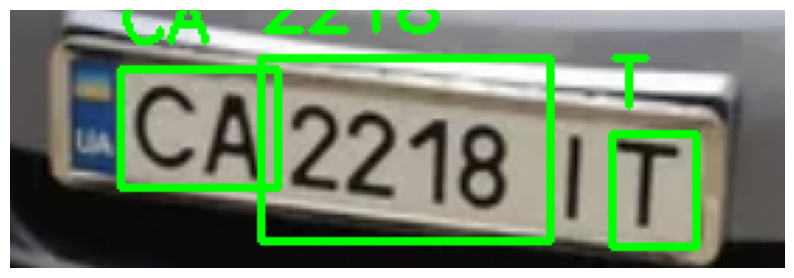

In [ ]:
# Image path and settings
image_path = "/Users/olgatsyban/Documents/car10.png"
langs = ["en"]  # Adjust if necessary
use_gpu = False  # Use GPU if available and properly configured

# Load and preprocess the image
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
_, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply thresholding

# OCR the preprocessed image using EasyOCR
print("[INFO] OCR'ing input image...")
reader = Reader(langs, gpu=use_gpu)
results = reader.readtext(binary_image)

# Loop over the results and draw bounding boxes
for (bbox, text, prob) in results:
    print("[INFO] {:.4f}: {}".format(prob, text))
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Convert BGR (OpenCV) to RGB (Matplotlib) and display the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()


